/tmp/ipykernel_863332/4220390058.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/remote_training/richard/a/chess/stage2_ckpts/2025_03

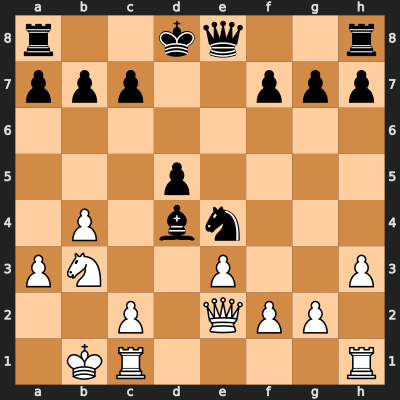

1/1 [==============================] - 0s 152ms/step


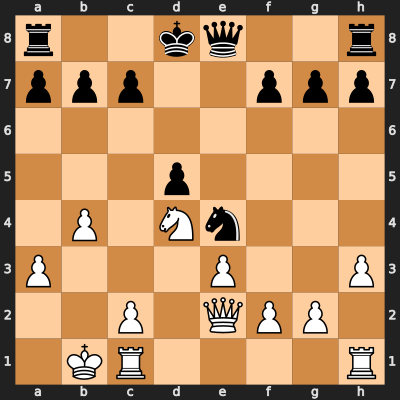

  5%|▌         | 1/20 [00:00<00:08,  2.37it/s]

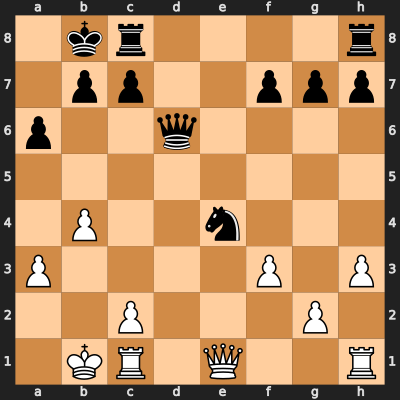

1/1 [==============================] - 0s 25ms/step


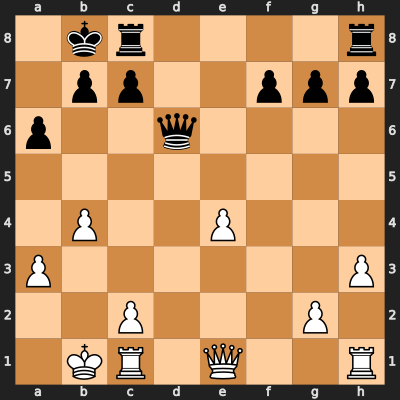

 10%|█         | 2/20 [00:00<00:04,  3.75it/s]

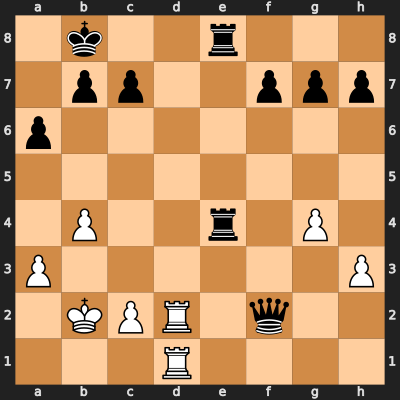

1/1 [==============================] - 0s 24ms/step


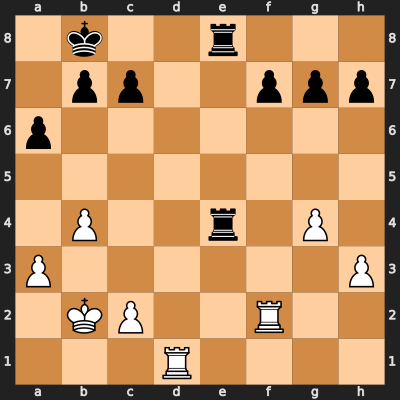

 15%|█▌        | 3/20 [00:00<00:03,  4.66it/s]

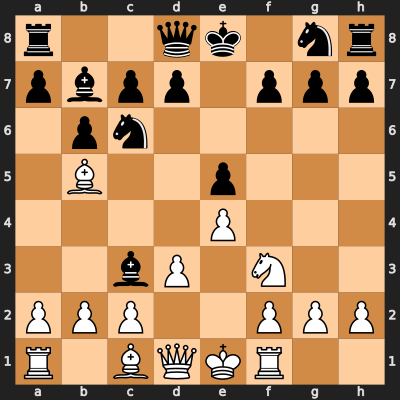

1/1 [==============================] - 0s 25ms/step


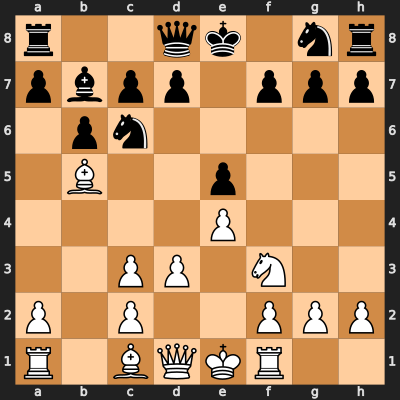

 20%|██        | 4/20 [00:00<00:03,  5.24it/s]

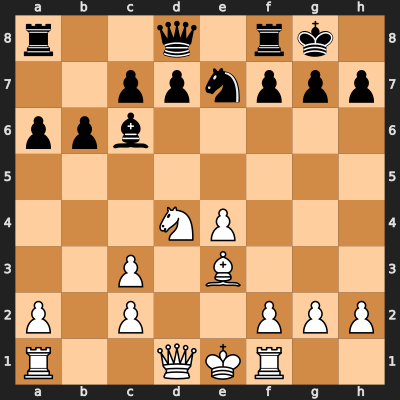

1/1 [==============================] - 0s 26ms/step


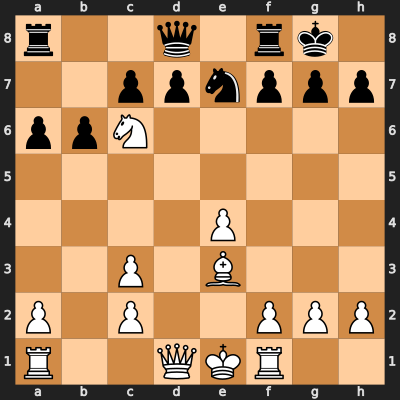

 25%|██▌       | 5/20 [00:01<00:02,  5.61it/s]

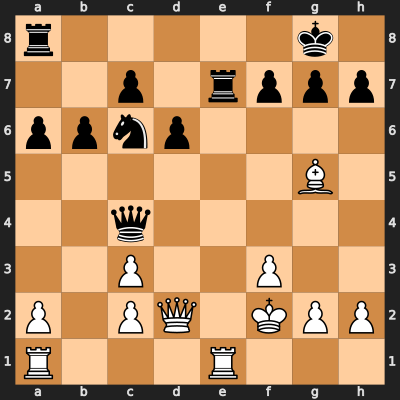

1/1 [==============================] - 0s 24ms/step


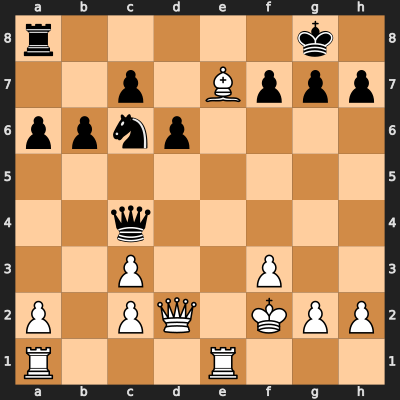

 30%|███       | 6/20 [00:01<00:02,  5.84it/s]

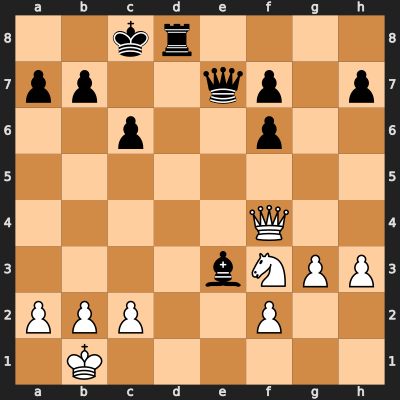

1/1 [==============================] - 0s 24ms/step


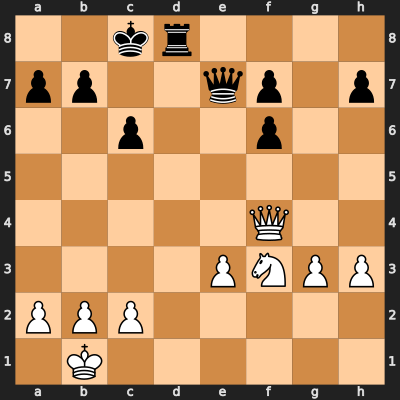

 35%|███▌      | 7/20 [00:01<00:02,  6.07it/s]

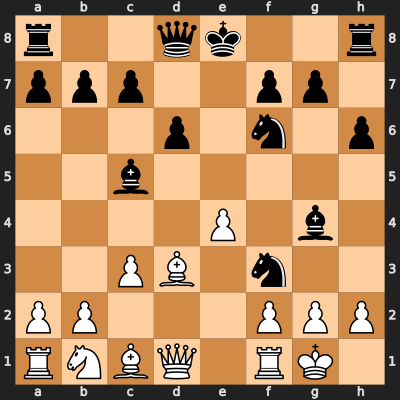

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7/20 [00:01<00:02,  4.72it/s]


IndexError: list index out of range

In [94]:
import torch
from chess_utils import ChessData_conv, ConvNet, board_to_two_tensors, tensor_to_board, moves_to_tensor, display_board
from tqdm import tqdm
import json
import os
import random
import wandb
import chess
import chess.svg
from IPython.display import display, SVG
from datetime import datetime
from tensorflow.keras.models import load_model
from players import HumanPlayer, AIPlayer
from draw import draw_background, draw_pieces


from_model = load_model('models/1200-elo/from.h5', compile=False)
to_model = load_model('models/1200-elo/to.h5', compile=False)
ai = AIPlayer(colour='white', from_model=from_model, to_model=to_model)


def ai_on_bench(before_set, after_set):
    accuracy_list = []

    # Run our model on both benchs
    for i in tqdm(range(20)):
        # Restore the board
        board = tensor_to_board(before_set[i])
        display(SVG(chess.svg.board(board=board, size=400)))

        move = ai.move(board=board, human_white=False)

        tensor_me_after, tensor_oppo_after = board_to_two_tensors(board, device) 
        accuracy_list.append(torch.equal(after_set[i], tensor_me_after))
        board = tensor_to_board(after_set[i])
        display(SVG(chess.svg.board(board=board, size=400)))


    return sum(accuracy_list) / len(accuracy_list)

def test_on_bench(before_set, after_set):
    accuracy_list = []

    # Run our model on both benchs
    for i in tqdm(range(20)):
        # Restore the board
        board = tensor_to_board(before_set[i])
        
        # Get the legal moves
        legal_moves = list(board.legal_moves)
        move_scores = {legal_move: None for legal_move in legal_moves}

        for legal_move in legal_moves:
            board.push(legal_move)

            tensor_me_after, tensor_oppo_after = board_to_two_tensors(board, device)   

            # Compute value for the move
            value_me_after, _ = model(tensor_me_after.unsqueeze(0))
            value_oppo_after, _ = model(tensor_oppo_after.unsqueeze(0))
            # move_scores[legal_move] = (value_me_after - value_oppo_after).item()    
            move_scores[legal_move] = (value_me_after - value_oppo_after + calculate_diff(tensor_me_after)).item()    

            board.pop()

        # move = sorted(move_scores.items(), key=lambda x: x[1], reverse=True)[0][0]
        move = epsilon_select(move_scores, epsilon) 

        board.push(move)
        tensor_me_after, tensor_oppo_after = board_to_two_tensors(board, device) 
        accuracy_list.append(torch.equal(after_set[i], tensor_me_after))

    return sum(accuracy_list) / len(accuracy_list)

def calculate_diff(tensor_board, scalar=1):
    sums = torch.sum(tensor_board, dim=(1, 2))
    score = 0.025 * (sums[0]) + 0.075 * (sums[1]) + 0.0875 * (sums[2]) + 0.125 * (sums[3]) + 0.225 * (sums[4])
    return scalar * score

def epsilon_select(move_scores, epsilon):
    """Select a move using epsilon-greedy strategy."""
    if random.random() < epsilon:
        return random.choice(list(move_scores.keys()))  # Random move
    else:
        return max(move_scores.items(), key=lambda x: x[1])[0]  # Best move

device = "cuda:0"
epsilon = 0

model = ConvNet(11, 256, 1)
model = model.to(device)
# model.load_state_dict(torch.load('/remote_training/richard/a/chess/ckpt/v3_good/model_15.pth'))
# model.load_state_dict(torch.load('/remote_training/richard/a/chess/stage2_ckpts/v4_good/model_9.pth'))
model.load_state_dict(torch.load('/remote_training/richard/a/chess/stage2_ckpts/2025_03_13_06h22m24s/model_55.pth'))

# Load data for two benchmarks
capture_before_set = torch.load('/remote_training/richard/a/chess/data/capture_before.pth')
capture_after_set = torch.load('/remote_training/richard/a/chess/data/capture_after.pth')
endgame_before_set = torch.load('/remote_training/richard/a/chess/data/endgame_before.pth')
endgame_after_set = torch.load('/remote_training/richard/a/chess/data/endgame_after.pth')

capture_accuracy_list = []


# capture_accuracy = test_on_bench(capture_before_set, capture_after_set)
# endgame_accuracy = test_on_bench(endgame_before_set, endgame_after_set)

capture_accuracy = ai_on_bench(capture_before_set, capture_after_set)
endgame_accuracy = ai_on_bench(endgame_before_set, endgame_after_set)

print(f'capture_accuracy: {capture_accuracy}, endgame_accuracy: {endgame_accuracy}.')




In [ ]:
import random

my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
random_selection = random.sample(my_list, 5)

print(random_selection)


[5, 4, 9, 7, 6]


## Form the end-game set

In [ ]:
import pandas as pd
import chess
from chess_utils import board_to_two_tensors, tensor_to_board
import torch


def endgame_to_tensor(df_row, gamma=0.98, alpha=1):
    moves = df_row['moves'].split()
    winner = df_row['winner']

    board = chess.Board()
    endgame_tensors_before = []
    endgame_tensors_after = []
    
    for i in range(len(moves)):
        move = moves[i]
        move_obj = board.parse_san(move)
        
        board.push(move_obj)  # Execute the move

        if board.is_checkmate():
            board.pop()
            board_tensor_white_before, board_tensor_black_before = board_to_two_tensors(board)
            board.push(move_obj)  # Execute the move
            board_tensor_white_after, board_tensor_black_after = board_to_two_tensors(board)

            # Check game outcome
            outcome = board.outcome()

            if outcome.winner == chess.WHITE:
                endgame_tensors_before.append(board_tensor_white_before)
                endgame_tensors_after.append(board_tensor_white_after)
            elif outcome.winner == chess.BLACK:
                endgame_tensors_before.append(board_tensor_black_before) 
                endgame_tensors_after.append(board_tensor_black_after)
            else:
                print("The game was a draw.")
        
    if not endgame_tensors_before:
        return None, None

    return torch.stack(endgame_tensors_before), torch.stack(endgame_tensors_after)

# Each row will be turned into 2L x 

# # Example usage:
# df = pd.DataFrame({
#     'moves': ['d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4'],
#     'winner': ['white']
# })

# endgame_tensors_before, endgame_tensors_after, avoid_tensors_before, avoid_tensors_after = endgame_to_tensor(df.iloc[0])

# print(endgame_tensors_before.shape)


In [ ]:
df_all.iloc[0]['moves']

'd4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4'

In [ ]:
from tqdm import tqdm

df_all = pd.read_csv('../games.csv')
endgame_tensors_before_list = []
endgame_tensors_after_list = []

test_start = int(len(df_all) * 0.90)
test_end = len(df_all)


# for i in tqdm(range(100)):
for i in tqdm(range(test_start, test_end)):
    row = df_all.iloc[i]
    # endgame_tensors, avoid_tensors = endgame_to_tensor(row, gamma=.98, alpha=1)
    endgame_tensors_before, endgame_tensors_after = endgame_to_tensor(row, gamma=.98, alpha=1)
    if endgame_tensors_before is not None:
        endgame_tensors_before_list.append(endgame_tensors_before)
        endgame_tensors_after_list.append(endgame_tensors_after)

endgame_tensor_before = torch.vstack(endgame_tensors_before_list)
endgame_tensors_after = torch.vstack(endgame_tensors_after_list)


  0%|          | 0/2006 [00:00<?, ?it/s]

100%|██████████| 2006/2006 [00:03<00:00, 664.56it/s]


In [ ]:
endgame_tensor_before.shape

torch.Size([596, 11, 8, 8])

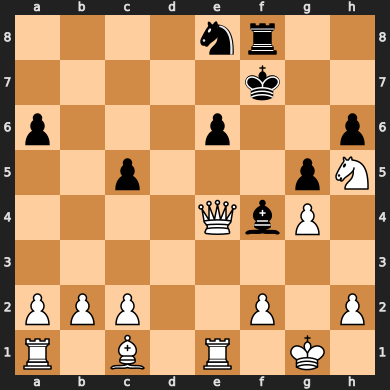

In [ ]:
board = tensor_to_board(endgame_tensor_before[52])

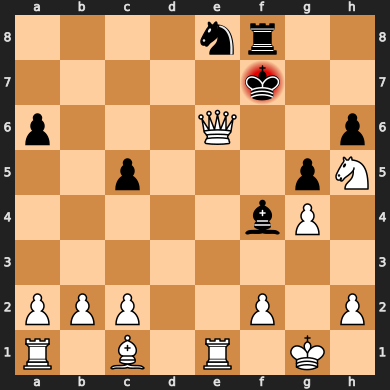

In [ ]:
tensor_to_board(endgame_tensors_after[52])

In [ ]:
torch.save(endgame_tensor_before, '/remote_training/richard/a/chess/data/endgame_before.pth')
torch.save(endgame_tensors_after, '/remote_training/richard/a/chess/data/endgame_after.pth')

## Form the capturing evalset

In [ ]:
import pandas as pd
import chess
from chess_utils import board_to_two_tensors, tensor_to_board
import torch


def captures_to_tensor(df_row, gamma=0.98, alpha=1):
    moves = df_row['moves'].split()
    winner = df_row['winner']

    board = chess.Board()
    capture_tensors_before = []
    capture_tensors_after = []
    avoid_tensors_before = []
    avoid_tensors_after = []
    
    # for i in range(len(moves)):
    #     move = moves[i]
    #     move_obj = board.parse_san(move)
        
    #     # Check if the move is a capture
    #     capture = board.is_capture(move_obj)

    #     if capture:
    #         board_tensor_white_before, board_tensor_black_before = board_to_two_tensors(board)
    #         board.push(move_obj)  # Execute the move
    #         board_tensor_white_after, board_tensor_black_after = board_to_two_tensors(board)

    #         if not board.turn:      # White moved
    #             capture_tensors_before.append(board_tensor_white_before)
    #             capture_tensors_after.append(board_tensor_white_after)
    #             avoid_tensors_before.append(board_tensor_black_before)
    #             avoid_tensors_after.append(board_tensor_black_after)

    #         else:       # Black moved
    #             # capture_tensors.append([board_tensor_black_before, board_tensor_black_after])
    #             # avoid_tensors.append([board_tensor_white_before, board_tensor_white_after])

    #             capture_tensors_before.append(board_tensor_black_before) 
    #             capture_tensors_after.append(board_tensor_black_after)
    #             avoid_tensors_before.append(board_tensor_white_before)
    #             avoid_tensors_after.append(board_tensor_white_after)
    #     else:
    #         board.push(move_obj)  # Execute the move
    
    # Piece values dictionary
    piece_values = {
        chess.QUEEN: 9 / 40,
        chess.ROOK: 5 / 40,
        chess.BISHOP: 3.5 / 40,
        chess.KNIGHT: 3 / 40,
        chess.PAWN: 1 / 40,
        chess.KING: 100  # King is invaluable, never captured
    }

    def get_piece_value(piece):
        """Returns the value of a piece, or 0 if it's None."""
        return piece_values.get(piece.piece_type, 0) if piece else 0

    for i in range(len(moves)):
        move = moves[i]
        move_obj = board.parse_san(move)

        # Check if the move is a capture
        captured_piece = board.piece_at(move_obj.to_square)
        moving_piece = board.piece_at(move_obj.from_square)

        if captured_piece and moving_piece:
            captured_value = get_piece_value(captured_piece)
            moving_value = get_piece_value(moving_piece)

            # Only process captures where a lower-value piece captures a higher-value piece
            if moving_value < captured_value:
                board_tensor_white_before, board_tensor_black_before = board_to_two_tensors(board)
                board.push(move_obj)  # Execute the move
                board_tensor_white_after, board_tensor_black_after = board_to_two_tensors(board)

                if not board.turn:  # White moved
                    capture_tensors_before.append(board_tensor_white_before)
                    capture_tensors_after.append(board_tensor_white_after)
                    avoid_tensors_before.append(board_tensor_black_before)
                    avoid_tensors_after.append(board_tensor_black_after)
                else:  # Black moved
                    capture_tensors_before.append(board_tensor_black_before)
                    capture_tensors_after.append(board_tensor_black_after)
                    avoid_tensors_before.append(board_tensor_white_before)
                    avoid_tensors_after.append(board_tensor_white_after)
                
                # print('Here')

            else:
                board.push(move_obj)  # Execute move normally if capture does not meet condition
        else:
            board.push(move_obj)  # Execute non-capture moves


    if not capture_tensors_before:
        return None, None, None, None

    return torch.stack(capture_tensors_before), torch.stack(capture_tensors_after), torch.stack(avoid_tensors_before), torch.stack(avoid_tensors_after)

# # Each row will be turned into 2L x 

# # Example usage:
# df = pd.DataFrame({
#     'moves': ['d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4'],
#     'winner': ['white']
# })

# capture_tensors_before, capture_tensors_after, avoid_tensors_before, avoid_tensors_after = captures_to_tensor(df.iloc[0])

# print(capture_tensors_before.shape)


In [ ]:
capture_tensors_before[0].shape

torch.Size([11, 8, 8])

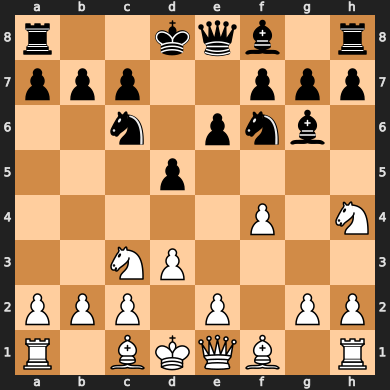

In [ ]:
tensor_to_board(capture_tensors_before[0])

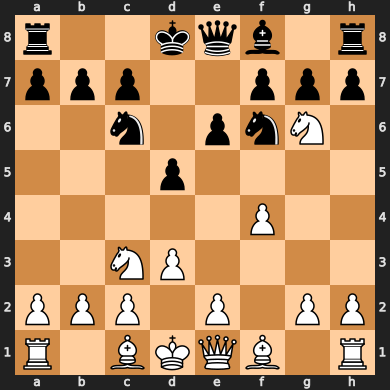

In [ ]:
tensor_to_board(capture_tensors_after[0])

In [ ]:
tensor_to_board(capture_tensors_before[2][1])

IndexError: too many indices for tensor of dimension 2

In [ ]:
from tqdm import tqdm

df_all = pd.read_csv('../games.csv')
capture_tensors_before_list = []
capture_tensors_after_list = []

test_start = int(len(df_all) * 0.95)
test_end = len(df_all)


# for i in tqdm(range(100)):
for i in tqdm(range(test_start, test_end)):
    row = df_all.iloc[i]
    # capture_tensors, avoid_tensors = captures_to_tensor(row, gamma=.98, alpha=1)
    capture_tensors_before, capture_tensors_after, avoid_tensors_before, avoid_tensors_after = captures_to_tensor(row, gamma=.98, alpha=1)
    if capture_tensors_before is not None:
        capture_tensors_before_list.append(capture_tensors_before)
        capture_tensors_after_list.append(capture_tensors_after)

capture_tensor_before = torch.vstack(capture_tensors_before_list)
capture_tensors_after = torch.vstack(capture_tensors_after_list)


  0%|          | 0/1003 [00:00<?, ?it/s]

100%|██████████| 1003/1003 [00:03<00:00, 314.30it/s]


In [ ]:
capture_tensor_before.shape

torch.Size([2606, 11, 8, 8])

In [ ]:
torch.save(capture_tensor_before, '/remote_training/richard/a/chess/data/capture_before.pth')
torch.save(capture_tensors_after, '/remote_training/richard/a/chess/data/capture_after.pth')

## Form the end-game evalset

In [ ]:
import torch

total_steps = torch.load('total.pth')

/tmp/ipykernel_1525737/3324550494.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  total_steps = torch.load('total.pth')


In [ ]:
total_steps.shape

torch.Size([2465770, 774])

In [ ]:
data = total_steps

In [ ]:
len(data)*0.9

2219193.0

In [ ]:
train_data = data[:2219193]
val_data = data[2219193:2342481]
test_data = data[2342481:]

In [ ]:
torch.save(train_data, 'train_data.pth')
torch.save(val_data, 'val_data.pth')
torch.save(test_data, 'test_data.pth')

In [ ]:
exp_data = data[-1000:]
torch.save(exp_data, 'data/exp_data.pth')

In [ ]:
import torch
import chess

def board_to_two_tensors(board):
    piece_order = [
        chess.PAWN, chess.KNIGHT, chess.BISHOP,
        chess.ROOK, chess.QUEEN, chess.KING
    ]

    def board_to_single_tensor(board, flip=False):
        tensor = torch.zeros((6, 8, 8), dtype=torch.float32)

        for i, piece_type in enumerate(piece_order):
            # White pieces
            for square in board.pieces(piece_type, chess.WHITE):
                row, col = divmod(square, 8)
                if flip:
                    tensor[i, 7 - row, 7 - col] = -1
                else:
                    tensor[i, row, col] = 1

            # Black pieces
            for square in board.pieces(piece_type, chess.BLACK):
                row, col = divmod(square, 8)
                if flip:
                    tensor[i, 7 - row, 7 - col] = 1
                else:
                    tensor[i, row, col] = -1

        castling_tensor = torch.tensor([
            board.has_kingside_castling_rights(chess.WHITE),
            board.has_queenside_castling_rights(chess.WHITE),
            board.has_kingside_castling_rights(chess.BLACK),
            board.has_queenside_castling_rights(chess.BLACK)
        ], dtype=torch.float32)

        turn_tensor = torch.tensor([1.0 if board.turn == chess.WHITE else 0.0], dtype=torch.float32)
        if flip:
            castling_tensor = castling_tensor[[2, 3, 0, 1]]
            turn_tensor = 1.0 - turn_tensor

        # print(tensor.shape)
        # print(castling_tensor.shape)        # (4, )
        # print(turn_tensor.shape)        # (1, )

        full_tensor = torch.cat([tensor, castling_tensor.view(4, 1, 1).expand(4, 8, 8), turn_tensor.view(1, 1, 1).expand(1, 8, 8)], dim=0)

        return full_tensor

    original_tensor = board_to_single_tensor(board, flip=False)
    flipped_tensor = board_to_single_tensor(board, flip=True)

    return original_tensor, flipped_tensor

def tensor_to_board(tensor):
    piece_order = [
        chess.PAWN, chess.KNIGHT, chess.BISHOP,
        chess.ROOK, chess.QUEEN, chess.KING
    ]

    board = chess.Board(None)  # Empty board
    piece_tensor = tensor[:6]
    castling_tensor = tensor[6:10][:, 0, 0]
    turn_tensor = tensor[10, 0, 0]

    # print(piece_tensor.shape, castling_tensor.shape, turn_tensor)

    for i, piece_type in enumerate(piece_order):
        for row in range(8):
            for col in range(8):
                if piece_tensor[i, 7 - row, col] == 1:
                    square = chess.square(col, 7 - row)
                    board.set_piece_at(square, chess.Piece(piece_type, chess.WHITE))
                if piece_tensor[i, 7 - row, col] == -1:
                    square = chess.square(col, 7 - row)
                    board.set_piece_at(square, chess.Piece(piece_type, chess.BLACK))

    board.turn = chess.WHITE if turn_tensor == 1 else chess.BLACK

    # Set castling rights
    if castling_tensor[0]:
        board.castling_rights |= chess.BB_H1
    if castling_tensor[1]:
        board.castling_rights |= chess.BB_A1
    if castling_tensor[2]:
        board.castling_rights |= chess.BB_H8
    if castling_tensor[3]:
        board.castling_rights |= chess.BB_A8

    return board

board = chess.Board()
board.push_san('e4')
board.push_san('e5')
board.push_san('g1f3')
board.push_san('b8c6')
board.push_san('f3e5')

board_tensor_white, board_tensor_black = board_to_two_tensors(board)
print(board_tensor_white.shape, board_tensor_black.shape)



torch.Size([11, 8, 8]) torch.Size([11, 8, 8])


In [ ]:
# reconstructed_board_white = tensor_to_board(board_tensor_white)
# print(board_tensor_white.shape, reconstructed_board_white.turn)
# reconstructed_board_white

In [ ]:
# Queen-9(9/40), rook-10(5/40), bishop-7(3.5/40), knight-6(3/40), pawn-8(1/40)
# white p - n - b - r - q - k - black p - n - b - r - q - k
# piece_order = [
#     chess.PAWN, chess.KNIGHT, chess.BISHOP,
#     chess.ROOK, chess.QUEEN, chess.KING
# ]

def calculate_diff(tensor_board, scalar=1):
    sums = torch.sum(tensor_board, dim=(1, 2))
    score = 0.025 * (sums[0]) + 0.075 * (sums[1]) + 0.0875 * (sums[2]) + 0.125 * (sums[3]) + 0.225 * (sums[4])
    return scalar * score

calculate_diff(board_tensor_black, scalar=1)


tensor(-0.0250)

In [ ]:
# reconstructed_board_black = tensor_to_board(board_tensor_black)
# print(board_tensor_black[-1], reconstructed_board_black.turn)
# reconstructed_board_black

In [ ]:
import pandas as pd

def moves_to_tensor(df_row, gamma=0.98, alpha=1):
    moves = df_row['moves'].split()
    winner = df_row['winner']

    board = chess.Board()
    tensors = []

    result_value = 1.0 if winner == 'white' else 0.0

    board_tensor_white, board_tensor_black = board_to_two_tensors(board)

    total_moves = len(moves)
    cur_advantage = calculate_diff(board_tensor_white, alpha)

    white_value = torch.tensor([result_value * (gamma ** (total_moves)) + cur_advantage])
    black_value = torch.tensor([-result_value * (gamma ** (total_moves)) - cur_advantage])

    full_tensor_white = torch.cat([board_tensor_white, white_value.view(1, 1, 1).expand(1, 8, 8)], dim=0)
    full_tensor_black = torch.cat([board_tensor_black, black_value.view(1, 1, 1).expand(1, 8, 8)], dim=0)
    
    tensors.append(full_tensor_white)
    tensors.append(full_tensor_black)

    for i in range(len(moves)):
        move = moves[i]
        board.push_san(move)
        board_tensor_white, board_tensor_black = board_to_two_tensors(board)

        cur_advantage = calculate_diff(board_tensor_white, alpha)
        white_value = torch.tensor([result_value * (gamma ** (total_moves - i - 1) + cur_advantage)])
        black_value = torch.tensor([-result_value * (gamma ** (total_moves - i - 1) - cur_advantage)])

        full_tensor_white = torch.cat([board_tensor_white, white_value.view(1, 1, 1).expand(1, 8, 8)], dim=0)
        full_tensor_black = torch.cat([board_tensor_black, black_value.view(1, 1, 1).expand(1, 8, 8)], dim=0)

        tensors.append(full_tensor_white)
        tensors.append(full_tensor_black)

    return torch.stack(tensors)

# Each row will be turned into 2L x 

# Example usage:
df = pd.DataFrame({
    'moves': ['d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4'],
    'winner': ['white']
})

move_tensor = moves_to_tensor(df.iloc[0])

print(move_tensor.shape)


torch.Size([28, 12, 8, 8])


In [ ]:
from tqdm import tqdm

df_all = pd.read_csv('games.csv')
tensor_list = []

# for i in tqdm(range(100)):
for i in tqdm(range(10)):
    row = df_all.iloc[i]
    move_tensors = moves_to_tensor(row, gamma=.98, alpha=0)
    tensor_list.append(move_tensors)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 52.67it/s]


In [ ]:
df_all.head(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3


In [ ]:
len(tensor_list)

20058

In [ ]:
total = torch.vstack(tensor_list)
total.shape

torch.Size([976, 12, 8, 8])

In [ ]:
for i in range(20):
    print(total[i, -1, 0, 0])

tensor(0.7690)
tensor(-0.7690)
tensor(0.7847)
tensor(-0.7847)
tensor(0.8007)
tensor(-0.8007)
tensor(0.8171)
tensor(-0.8171)
tensor(0.8337)
tensor(-0.8337)
tensor(0.8508)
tensor(-0.8508)
tensor(0.8681)
tensor(-0.8681)
tensor(0.8858)
tensor(-0.8858)
tensor(0.9039)
tensor(-0.9039)
tensor(0.9224)
tensor(-0.9224)


tensor(0.9800)


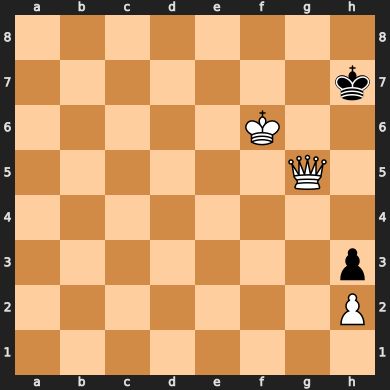

In [ ]:
tensor = total[-4]
print(tensor[-1, 0, 0])
board = tensor_to_board(tensor)
board

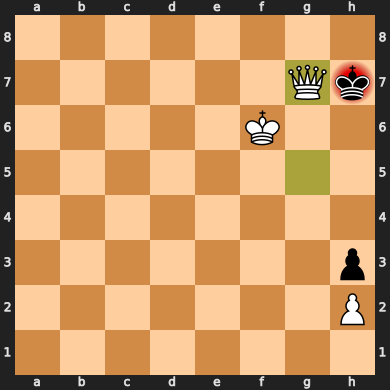

In [ ]:
board.push(chess.Move.from_uci('g5g7'))
board

In [ ]:
total.shape

torch.Size([2465770, 12, 8, 8])

In [ ]:
torch.save(total, 'data/total_conv_v4.pth')

## Train/Val split

In [ ]:
# v2: 17,8,8, with alpha=5
# v3: 11,8,8, with alpha=1
# v4: 11,8,8, with alpha=0

In [ ]:
len_total = len(total)
train = total[ : int(.9*len_total)]
val = total[int(.9*len_total) : int(.95*len_total)]
test = total[int(.95*len_total) : ]
exp = total[int(.9999*len_total) :]

In [ ]:
torch.save(train, 'data/train_conv_v4.pth')
torch.save(val, 'data/val_conv_v4.pth')
torch.save(test, 'data/test_conv_v4.pth')
torch.save(exp, 'data/exp_conv_v4.pth')


In [ ]:
len(exp)

24658